In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import math
import statsmodels.api as sm
import pylab
%matplotlib inline

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')

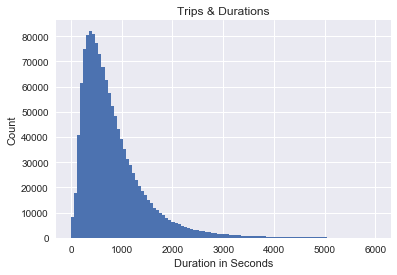

In [227]:
df_train.trip_duration.hist(bins=100)
plt.title('Trips & Durations')
plt.ylabel('Count')
plt.xlabel('Duration in Seconds')

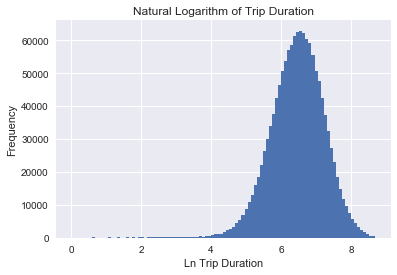

In [231]:
df_train['log_trip_duration'] = np.log(df_train['trip_duration'].values)
df_train['log_trip_duration'].plot.hist(bins=100)
plt.title('Natural Logarithm of Trip Duration')
plt.xlabel('Ln Trip Duration')

In [4]:
df_train['trip_duration'].max()/3600

979.52277777777783

In [230]:
np.log(834)

6.7262334023587469

In [225]:
df_train['trip_duration'].describe()

count    1.330033e+06
mean     8.344028e+02
std      6.490852e+02
min      1.000000e+00
25%      3.960000e+02
50%      6.610000e+02
75%      1.072000e+03
max      5.999000e+03
Name: trip_duration, dtype: float64

In [6]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_train.loc[:, 'pickup_date'] = df_train['pickup_datetime'].dt.date
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.date
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)
df_train['store_and_fwd_flag'] = 1 * (df_train.store_and_fwd_flag.values == 'Y')
df_test['store_and_fwd_flag'] = 1 * (df_test.store_and_fwd_flag.values == 'Y')
df_train['check_trip_duration'] = (df_train['dropoff_datetime'] - df_train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = df_train[np.abs(df_train['check_trip_duration'].values  - df_train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [7]:
df_train.loc[:, 'pickup_weekday'] = df_train['pickup_datetime'].dt.weekday
df_train.loc[:, 'pickup_hour_weekofyear'] = df_train['pickup_datetime'].dt.weekofyear
df_train.loc[:, 'pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train.loc[:, 'pickup_minute'] = df_train['pickup_datetime'].dt.minute
df_train.loc[:, 'pickup_dt'] = (df_train['pickup_datetime'] - df_train['pickup_datetime'].min()).dt.total_seconds()
df_train.loc[:, 'pickup_week_hour'] = df_train['pickup_weekday'] * 24 + df_train['pickup_hour']
df_train['Month'] = df_train['pickup_datetime'].dt.month
df_test['Month'] = df_test['pickup_datetime'].dt.month

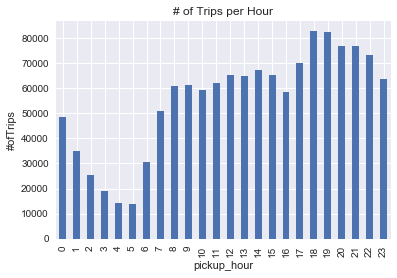

In [232]:
df_train.groupby(['pickup_hour']).size().plot.bar()
plt.title('# of Trips per Hour')
plt.ylabel('#ofTrips')
#number of trips each hour, peaking around dinner time

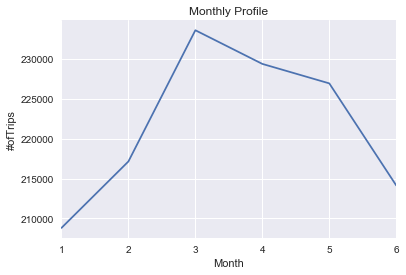

In [233]:
df_train.groupby(['Month']).size().plot.line()
plt.ylabel('#ofTrips')
plt.title('Monthly Profile')
#strange that data is only 6 months of the year???

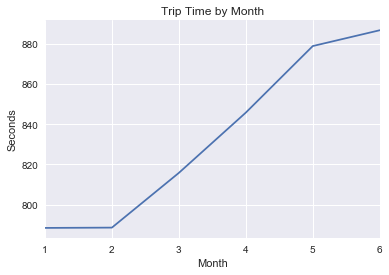

In [234]:
df_train.groupby(['Month'])['trip_duration'].mean().plot.line()
plt.title('Trip Time by Month')
plt.ylabel('Seconds')
#do the trip times increase as a result of summer?

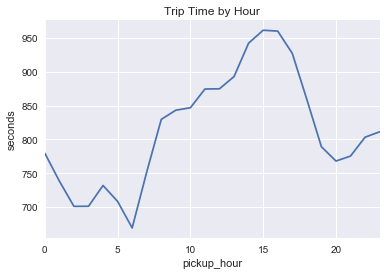

In [235]:
df_train.groupby(['pickup_hour'])['trip_duration'].mean().plot.line()
plt.ylabel('seconds')
plt.title('Trip Time by Hour')
#do the trip times increase as a result of rush hour? not really it seems there is a big peak at 3pm
#lulls in ridership in early morning and around 8pm

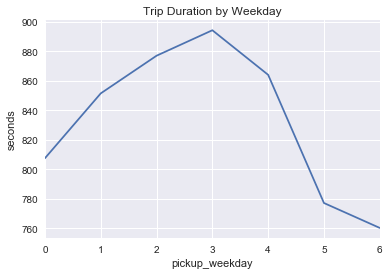

In [236]:
df_train.groupby(['pickup_weekday'])['trip_duration'].mean().plot.line()
plt.ylabel('seconds')
plt.title('Trip Duration by Weekday')
#peak traffic on wednesdays

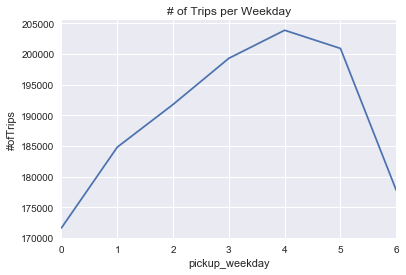

In [238]:
df_train.groupby(['pickup_weekday']).size().plot.line()
plt.title('# of Trips per Weekday')
plt.ylabel('#ofTrips')

In [13]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,pickup_date,check_trip_duration,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,Month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,6.120297,2016-03-14,455.0,0,11,17,24,6369878.0,17,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,6.496775,2016-06-12,663.0,6,23,0,43,14085798.0,144,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,7.661056,2016-01-19,2124.0,1,3,11,35,1596907.0,35,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,6.061457,2016-04-06,429.0,2,14,19,32,8364734.0,67,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,6.075346,2016-03-26,435.0,5,12,13,30,7392638.0,133,3


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 21 columns):
id                        1458644 non-null object
vendor_id                 1458644 non-null int64
pickup_datetime           1458644 non-null datetime64[ns]
dropoff_datetime          1458644 non-null datetime64[ns]
passenger_count           1458644 non-null int64
pickup_longitude          1458644 non-null float64
pickup_latitude           1458644 non-null float64
dropoff_longitude         1458644 non-null float64
dropoff_latitude          1458644 non-null float64
store_and_fwd_flag        1458644 non-null int64
trip_duration             1458644 non-null int64
log_trip_duration         1458644 non-null float64
pickup_date               1458644 non-null object
check_trip_duration       1458644 non-null float64
pickup_weekday            1458644 non-null int64
pickup_hour_weekofyear    1458644 non-null int64
pickup_hour               1458644 non-null int64
pickup_minute         

In [15]:
df_train['passenger_count'].describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

In [16]:
df_train = df_train[df_train['passenger_count']<5]

In [17]:
df_train = df_train[df_train['trip_duration']<6000]
df_train['trip_duration'].describe()

count    1.330033e+06
mean     8.344028e+02
std      6.490852e+02
min      1.000000e+00
25%      3.960000e+02
50%      6.610000e+02
75%      1.072000e+03
max      5.999000e+03
Name: trip_duration, dtype: float64

Explore the following using hypothesis testing or correlations:
 1. Is there a statistical difference between the taxi vendors trip durations?
 - trip duration vs passenger count
 - trip duration vs time of year (seasonal, i.e. summer/winter)
 - impact of rush hour on trip duration
 - demonstrate the trip durations to airports is related to the pickup distance from the airport
 - trip duration vs total distance (need to import the OCRM data)
 
 
 Cleaning Data:
 - remove the super long trips: set limit to no more than 100minutes
 - remove the trips with >5 passengers : removed all trips with passengers >5
 - remove trips that have zero distance and greater than 5 minutes  <<<don't know how to do yet>>>

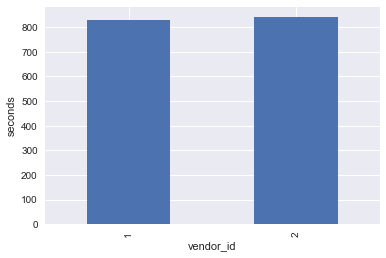

In [61]:
df_train.groupby(['vendor_id'])['trip_duration'].mean().plot.bar()
plt.ylabel('seconds')

In [19]:
vendor1_df = df_train[df_train['vendor_id']==1]
vendor2_df = df_train[df_train['vendor_id']==2]

trip = df_train.as_matrix(columns=['trip_duration'])

vendor1_trip = vendor1_df.as_matrix(columns=['trip_duration'])
vendor2_trip = vendor2_df.as_matrix(columns=['trip_duration'])

mu_vendor1 = np.mean(vendor1_trip)
sig_vendor1 = np.std(vendor1_trip)

mu_vendor2 = np.mean(vendor2_trip)
sig_vendor2 = np.std(vendor2_trip)

mu_trip = np.mean(trip)
sig_trip = np.std(trip)

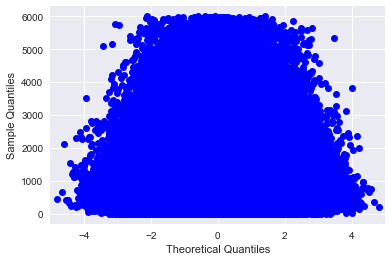

In [20]:
sm.qqplot(trip)
pylab.show()

In [21]:
stats.mstats.normaltest(trip)

NormaltestResult(statistic=masked_array(data = [601718.7160193013],
             mask = [False],
       fill_value = 1e+20)
, pvalue=array([ 0.]))

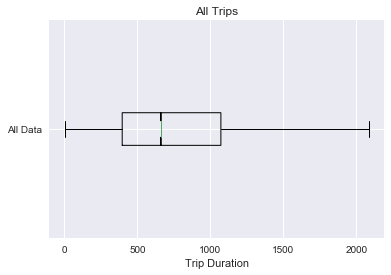

In [22]:
plt.figure()
plt.boxplot([trip],1 ,'rs',0, labels=['All Data'],showfliers=False)
plt.xlabel('Trip Duration')
plt.title('All Trips')
None

In [23]:
df_train.groupby(['vendor_id'])['id'].count()
#huge sample, probably will use z-stat assuming it is representative of the population standard deviation

vendor_id
1    677637
2    652396
Name: id, dtype: int64

In [24]:
def get_z(sample1, sample2):
    z = (np.mean(sample1) - np.mean(sample2)) / math.sqrt(np.std(sample1)**2/len(sample1)+np.std(sample2)**2/len(sample2))
    return z


def get_t(sample, null_hypo):
    t = (np.mean(sample) - null_hypo) / (np.std(sample) / math.sqrt(len(sample)))
    return t

In [224]:
z = get_z(vendor1_trip, vendor2_trip)
print('Z statastic:', z)
#makes it very unlikely that the means are statistically equal, null hypothesis will be rejected

Z statastic: -10.1915132951


Ho: mu1 - mu2 = deltao
Ha: mu1 - mu2 < deltao

This is to say that for Ha, the mean trip duration of vendor 1 is less than mean trip duration of vendor 2. This inequality indicates a lower tailed test where we reject the null hypothesis if z<= -zalpha

For an alpha value of 0.95 the Zcritical value is 1.65 meaning that in order to reject the null hypothesis our calculated statistic has to be z<= -1.65.

In this case our z statistic is -10.2 which is less than -1.65 and so we must reject the null hypothesis that the mean trip durations are equal and accept that vendor 1 has a lower mean trip duration than vendor 2.

The P-value is also 0 meaning Ho should be rejected for any reasonable significance level.

It is also fair to say that although the means are different, they are not different by much and this will likely not be a significant factor in determining trip duration.

# Series of Box Plots

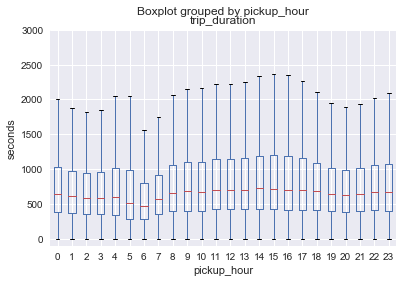

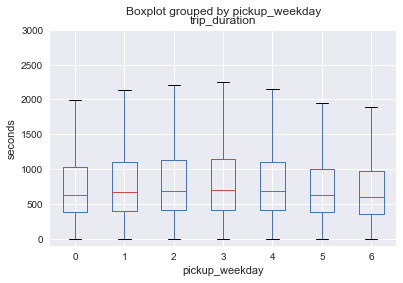

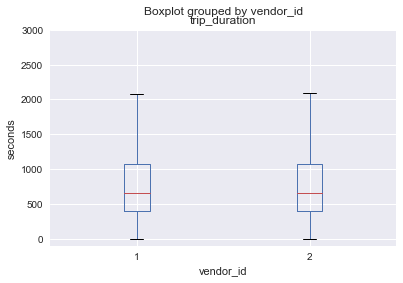

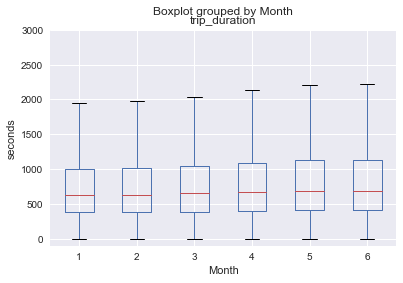

In [65]:
#how do i use matplotlib axis objects?
ax=df_train.boxplot(column='trip_duration',by='pickup_hour')
ax.set_ylim(-100,3000)
ax.set_ylabel ('seconds')

ax1=df_train.boxplot(column='trip_duration',by='pickup_weekday')
ax1.set_ylim(-100,3000)
ax1.set_ylabel ('seconds')

ax2=df_train.boxplot(column='trip_duration',by='vendor_id')
ax2.set_ylim(-100,3000)
ax2.set_ylabel ('seconds')

ax3=df_train.boxplot(column='trip_duration',by='Month')
ax3.set_ylim(-100,3000)
ax3.set_ylabel ('seconds')

# Test for Correlation Between Trip Duration & Passenger Count

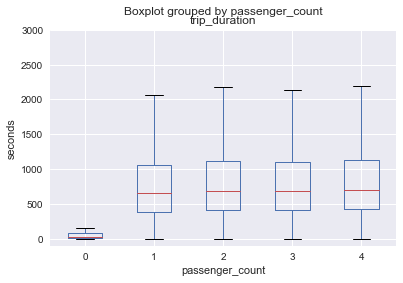

In [74]:
ax4=df_train.boxplot(column='trip_duration',by='passenger_count')
ax4.set_ylim(-100,3000)
ax4.set_ylabel('seconds')

# Lets add in the direct distance formulas & calculate average speed

In [75]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [77]:
df_train.loc[:, 'distance_haversine'] = haversine_array(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)
    
df_train.loc[:, 'direction'] = bearing_array(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)

df_train.loc[:, 'speed'] = 1000*df_train['distance_haversine']/df_train['trip_duration']

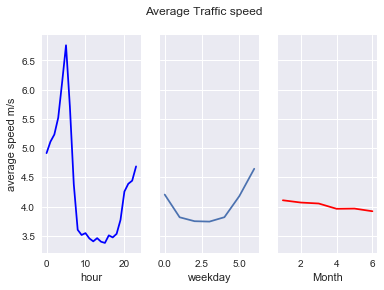

In [91]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df_train.groupby('pickup_hour')['speed'].mean(),'b-')
ax[1].plot(df_train.groupby('pickup_weekday')['speed'].mean())
ax[2].plot(df_train.groupby('Month')['speed'].mean(), 'r-')
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('Month')
ax[0].set_ylabel('average speed m/s')
fig.suptitle('Average Traffic speed')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'set_ylim'

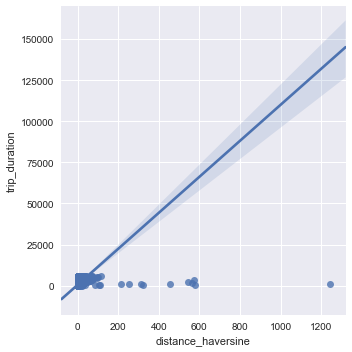

In [97]:
lm = sns.lmplot(x='distance_haversine',y='trip_duration',data=df_train)

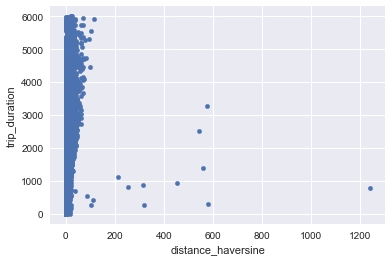

In [104]:
df_train.plot.scatter(x='distance_haversine',y='trip_duration')
#plt.ylim(0,2000)
#plt.xlim(0,25)

# Training the Model

In [223]:
#dow_train = pd.get_dummies(df_train['pickup_weekday'], prefix='dow', prefix_sep='_')
#master_train = pd.concat([df_train,dow_train],axis=1)
#master_train.head(5)

In [195]:
X = df_train[['Month','pickup_hour','pickup_weekday','distance_haversine','vendor_id','passenger_count']]
y = df_train['trip_duration']
#should we add the cluster number to the dataset as an analogue for neighbourhood?

In [196]:
from sklearn.model_selection import train_test_split

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [198]:
from sklearn.linear_model import LinearRegression

In [199]:
lm = LinearRegression()

In [200]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [201]:
# The coefficients
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [  18.27301332    3.90016961  -12.07745668  105.16489432    2.66860707
   15.10954156]


## Predicting Test Data
Now that we have fit our model, let's evaluate its performance by predicting off the test values!

** Use lm.predict() to predict off the X_test set of the data.**

In [202]:
predictions = lm.predict( X_test)

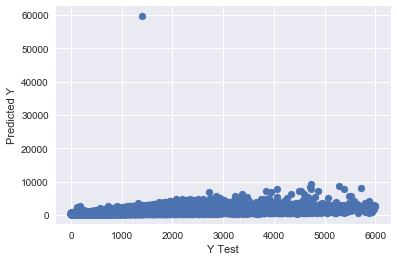

In [203]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

## Evaluating the Model

Let's evaluate our model performance by calculating the residual sum of squares and the explained variance score (R^2).

** Calculate the Mean Absolute Error, Mean Squared Error, and the Root Mean Squared Error. Refer to the lecture or to Wikipedia for the formulas**

In [204]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 297.663310569
MSE: 185540.117878
RMSE: 430.743680021


In [221]:
print('R Squared: ', metrics.r2_score(y_test,predictions))

R Squared:  0.563117959804


## Residuals

Let's quickly explore the residuals to make sure everything was okay with our data. 

**Plot a histogram of the residuals and make sure it looks normally distributed.**

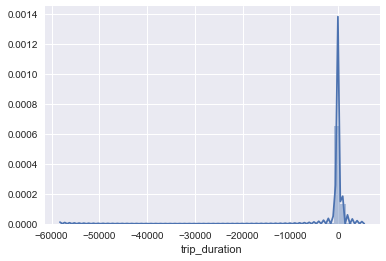

In [240]:
sns.distplot((y_test-predictions),bins=50)


## Conclusion



In [210]:
coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coefficient']
coeffecients.sort_values(by='Coefficient',ascending=False)

,Coefficient
distance_haversine,105.164894
Month,18.273013
passenger_count,15.109542
pickup_hour,3.900170
vendor_id,2.668607
pickup_weekday,-12.077457
